In [1]:
import numpy as np

wt = np.loadtxt("../data/wt_bin_fpkm.txt", skiprows=1)
uv = np.loadtxt("../data/UV_bin_fpkm.txt", skiprows=1)
dr = np.loadtxt("../data/ebfC_bin_fpkm.txt", skiprows=1)

In [2]:
import pandas as pd
import re
import os

def _get_attr(attributes, attr_id, ignore=False):
    """
    Helper function for parsing GFF annotations

    Parameters
    ----------
    attributes : str
        Attribute string
    attr_id : str
        Attribute ID
    ignore : bool
        If true, ignore errors if ID is not in attributes (default: False)

    Returns
    -------
    str, optional
        Value of attribute
    """

    try:
        return re.search(attr_id + "=(.*?)(;|$)", attributes).group(1)
    except AttributeError:
        if ignore:
            return None
        else:
            raise ValueError("{} not in attributes: {}".format(attr_id, attributes))

gff_files = [os.path.join('../data/GCF_000008565.1_ASM856v1_genomic.gff')]

for gff in gff_files:
    with open(gff, "r") as f:
        lines = f.readlines()

    # Read GFF
    names = [
        "accession",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "phase",
        "attributes",
        ]
    DF_gff = pd.read_csv(gff, sep="\t", names=names)
    # Filter for CDSs 
    DF_cds = DF_gff[DF_gff['feature']=='CDS']
    # Also filter for genes to get old_locus_tag
    DF_gene = DF_gff[DF_gff.feature == "gene"].reset_index()
    DF_gene["locus_tag"] = DF_gene.attributes.apply(_get_attr, attr_id="locus_tag", ignore=True)
    DF_gene["old_locus_tag"] = DF_gene.attributes.apply(_get_attr, attr_id="old_locus_tag", ignore=True)
    DF_gene = DF_gene[["locus_tag", "old_locus_tag"]]
    DF_gene = DF_gene[DF_gene.locus_tag.notnull()]

    # Sort by start position
    DF_cds = DF_cds.sort_values("start")

    # Extract attribute information
    DF_cds["locus_tag"] = DF_cds.attributes.apply(_get_attr, attr_id="locus_tag")

    DF_cds["gene_name"] = DF_cds.attributes.apply(_get_attr, attr_id="gene", ignore=True)

    DF_cds["gene_product"] = DF_cds.attributes.apply(_get_attr, attr_id="product", ignore=True)

    DF_cds["ncbi_protein"] = DF_cds.attributes.apply(_get_attr, attr_id="protein_id", ignore=True)

    # Merge in old_locus_tag
    DF_annot = pd.merge(DF_cds, DF_gene, how="left", on="locus_tag", sort=False)
    
DF_annot1 = DF_annot[DF_annot['accession']=='NC_001263.1']
DF_annot1 = DF_annot1.drop_duplicates(subset='locus_tag',keep='first',inplace=False)
DF_annot1 = DF_annot1.reset_index(drop=True)
keep_cols = ['accession','locus_tag','start','end']
DF_annot1 = DF_annot1[keep_cols]
DF_annot1['bin'] = (DF_annot1['start'] / 5000).astype(int)
DF_annot1

,accession,locus_tag,start,end,bin
0,NC_001263.1,DR_RS00005,93.0,1179.0,0
1,NC_001263.1,DR_RS00010,1904.0,3304.0,0
2,NC_001263.1,DR_RS00015,3556.0,4251.0,0
3,NC_001263.1,DR_RS00020,4387.0,5430.0,0
4,NC_001263.1,DR_RS00025,5438.0,6115.0,1
...,...,...,...,...,...
2669,NC_001263.1,DR_RS13555,2642825.0,2643265.0,528
2670,NC_001263.1,DR_RS13560,2643262.0,2644083.0,528
2671,NC_001263.1,DR_RS13565,2644270.0,2645499.0,528
2672,NC_001263.1,DR_RS13570,2645698.0,2647146.0,529


# ultraviolet irradiation vs. control 

In [3]:
diff_data = pd.read_csv("../data/UV_DEGs_log2_1.csv", sep=',')
diff_data = pd.merge(DF_annot1, diff_data, how='left', left_on='locus_tag', right_on='gene_id')
diff_data

,accession,locus_tag,start,end,bin,gene_id,log2FoldChange,pvalue,padj,direction
0,NC_001263.1,DR_RS00005,93.0,1179.0,0,DR_RS00005,-0.317064,2.028248e-01,3.034066e-01,ns
1,NC_001263.1,DR_RS00010,1904.0,3304.0,0,DR_RS00010,-0.099242,7.325733e-01,8.143006e-01,ns
2,NC_001263.1,DR_RS00015,3556.0,4251.0,0,DR_RS00015,6.760954,5.242041e-62,9.575462e-60,up
3,NC_001263.1,DR_RS00020,4387.0,5430.0,0,DR_RS00020,-0.685797,2.887664e-03,9.042513e-03,ns
4,NC_001263.1,DR_RS00025,5438.0,6115.0,1,DR_RS00025,-0.373233,5.275899e-02,1.018347e-01,ns
...,...,...,...,...,...,...,...,...,...,...
2669,NC_001263.1,DR_RS13555,2642825.0,2643265.0,528,DR_RS13555,-0.007975,9.754618e-01,9.825971e-01,ns
2670,NC_001263.1,DR_RS13560,2643262.0,2644083.0,528,DR_RS13560,0.194654,4.464380e-01,5.595331e-01,ns
2671,NC_001263.1,DR_RS13565,2644270.0,2645499.0,528,DR_RS13565,0.296739,2.876224e-01,3.993676e-01,ns
2672,NC_001263.1,DR_RS13570,2645698.0,2647146.0,529,DR_RS13570,-0.448948,1.700695e-02,4.040379e-02,ns


In [4]:
data = diff_data[['bin','direction']]
res_array = np.array(data)

result = []
for i in range(530):
    count = 0
    for j in res_array:
        if j[0]==i:
            if j[1]=='up':
                count += 1
    result.append([i,count])
    
result1 = []
for i in range(len(result)):
    num = 0
    for j in range(i-10,i+11):
        num += result[j%530][1]
    result1.append([i,num])

from pandas.core.frame import DataFrame
data=DataFrame(result1)

In [5]:
DR = np.loadtxt('../data/MAT_scn_wt.txt')
UV = np.loadtxt('../data/MAT_scn_uv.txt')

import sys
sys.path.append("../python_codes/")
import directional_indice
scales2 = 20

wt_chr1 = DR[:530,:530]
wt_chr2 = DR[530:613,530:613]
wt_DI20_chr1 = directional_indice.directional(wt_chr1,scales2)
wt_DI20_chr2 = directional_indice.directional(wt_chr2,scales2)

uv_chr1 = UV[:530,:530]
uv_chr2 = UV[530:613,530:613]
uv_DI20_chr1 = directional_indice.directional(uv_chr1,scales2)
uv_DI20_chr2 = directional_indice.directional(uv_chr2,scales2)

Size of the matrix entetered for the directional index:
530
Size of the matrix entetered for the directional index:
83
Size of the matrix entetered for the directional index:
530
Size of the matrix entetered for the directional index:
83


In [6]:
def CID_identify(borders, thr, bin_num):
    CID = []
    for i in borders:
        if i >= thr:
            CID.append(thr)
        if i <= -thr:
            CID.append(-thr)
        if i < thr and i > -thr:
            CID.append(i)

    CID_Boundary_count = 0
    CID_Boundary = []
    for i in range(bin_num):
        try:
            d = CID.index(thr,i)
            if CID[i] == -thr and CID[i+1:d].count(-thr) == 0:
                CID_Boundary_count = CID_Boundary_count + 1
                CID_Boundary.append([i,d])
        except ValueError:
            pass
    return CID_Boundary_count, CID_Boundary

CID_Boundary_count1, CID_Boundary1 = CID_identify(wt_DI20_chr1[:,0], 2, 530)
print(CID_Boundary_count1)
print(CID_Boundary1)
CID_Boundary_count2, CID_Boundary2 = CID_identify(wt_DI20_chr2[:,0], 2, 83)
print(CID_Boundary_count2)
print(CID_Boundary2)

uv_CID_Boundary_count1, uv_CID_Boundary1 = CID_identify(uv_DI20_chr1[:,0], 2, 530)
print(uv_CID_Boundary_count1)
print(uv_CID_Boundary1)
uv_CID_Boundary_count2, uv_CID_Boundary2 = CID_identify(uv_DI20_chr2[:,0], 2, 83)
print(uv_CID_Boundary_count2)
print(uv_CID_Boundary2)

21
[[3, 5], [49, 50], [64, 68], [86, 88], [109, 118], [138, 143], [174, 176], [198, 199], [206, 216], [227, 241], [251, 254], [263, 271], [285, 288], [296, 302], [352, 360], [368, 401], [410, 414], [438, 442], [456, 457], [491, 494], [516, 517]]
2
[[0, 1], [52, 53]]
15
[[3, 5], [49, 55], [61, 64], [132, 137], [182, 186], [209, 212], [229, 234], [250, 254], [265, 270], [299, 309], [334, 339], [347, 370], [425, 429], [471, 478], [481, 486]]
3
[[8, 9], [52, 53], [73, 76]]


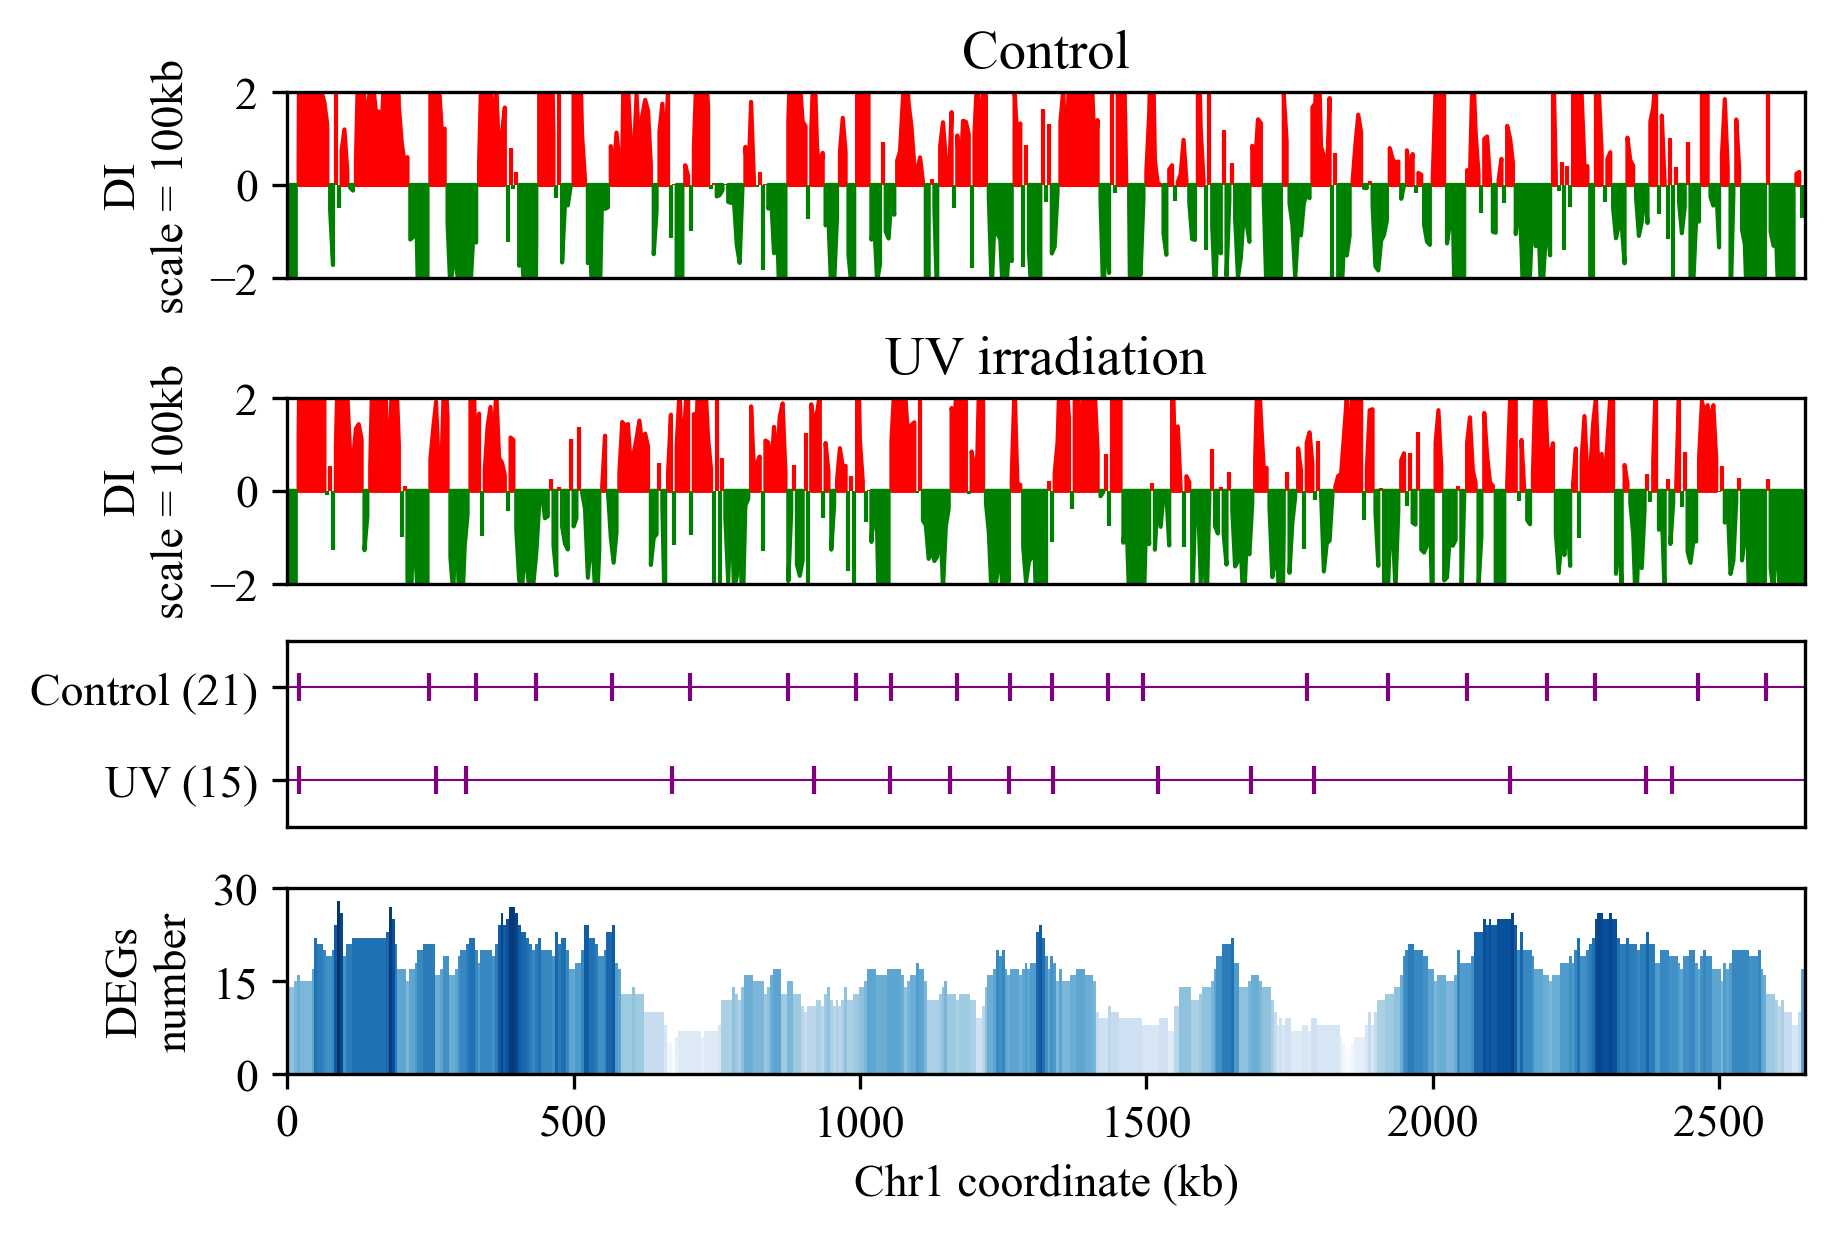

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylab import *
fig = plt.figure(figsize=(6, 4), dpi=300, constrained_layout=True)
plt.rc('font',family='Times New Roman')
matplotlib.rcParams.update({'font.size': 11})

gs = gridspec.GridSpec(4, 1, figure=fig)
ax0 = plt.subplot(gs[0])
borders = list(range(len(wt_DI20_chr1)))
borders1 = np.array(wt_DI20_chr1[:,0])
ax0.set_xlim([0, 530])
ax0.set_ylim([-2, 2])
ax0.fill_between(borders, 0,borders1,borders1>=0, color='red')
ax0.fill_between(borders, 0,borders1,borders1<0, color='green')
ax0.set_ylabel("DI\nscale = 100kb")
tick_locs = range(0,530,100)
tick_lbls = (np.array( range(0,530,100)) * 5 ).tolist()
plt.xticks(tick_locs, tick_lbls)
ax0.set_title('Control')
ax0.xaxis.set_visible(False)

ax1 = plt.subplot(gs[1], sharex=ax0)
borders2 = np.array(uv_DI20_chr1[:,0])
ax1.set_ylim([-2, 2])
ax1.fill_between(borders, 0,borders2,borders2>=0, color='red')
ax1.fill_between(borders, 0,borders2,borders2<0, color='green')
ax1.set_ylabel("DI\nscale = 100kb")
ax1.set_title('UV irradiation')
ax1.xaxis.set_visible(False)

ax3 = plt.subplot(gs[2], sharex=ax0)
ax3.set_ylim([0, 0.8])
ax3.set_yticks([0.2,0.6])
ax3.set_yticklabels(['UV (15)', 'Control (21)'])
ax3.hlines([0.2, 0.6], 0, 530, color ="purple", lw=0.5)
for i in CID_Boundary1:
    ax3.vlines((i[0]+i[1])/2, 0.54, 0.66, colors='purple', lw=1)
for i in uv_CID_Boundary1:
    ax3.vlines((i[0]+i[1])/2, 0.14, 0.26, colors='purple', lw=1)
ax3.xaxis.set_visible(False)

ax4 = plt.subplot(gs[3], sharex=ax0)
from matplotlib import cm
norm = plt.Normalize(data[1].values.min(), data[1].values.max())
norm_values = norm(data[1].values)
map_vir = cm.get_cmap(name='Blues')
color = map_vir(norm_values)
ax4.bar(data[0].values, data[1].values, color=color, width=1)
ax4.set_ylim([0, 30])
plt.yticks([0,15,30], [0,15,30])
ax4.set_xlabel("Chr1 coordinate (kb)")
ax4.set_ylabel("DEGs\nnumber")

plt.savefig("../pictures/UV_DEGs_distribution.jpg", bbox_inches='tight', dpi=300)

# ΔDr_ebfC mutant vs. wild type

In [8]:
diff_data = pd.read_csv("../data/ebfC_DEGs_log2_1.csv", sep=',')
diff_data = pd.merge(DF_annot1, diff_data, how='left', left_on='locus_tag', right_on='gene_id')
diff_data

,accession,locus_tag,start,end,bin,gene_id,log2FoldChange,pvalue,padj,direction
0,NC_001263.1,DR_RS00005,93.0,1179.0,0,DR_RS00005,-0.567395,3.077615e-02,5.532979e-02,ns
1,NC_001263.1,DR_RS00010,1904.0,3304.0,0,DR_RS00010,-0.723878,5.261300e-04,1.609626e-03,ns
2,NC_001263.1,DR_RS00015,3556.0,4251.0,0,DR_RS00015,3.095027,2.830000e-24,4.240000e-22,up
3,NC_001263.1,DR_RS00020,4387.0,5430.0,0,DR_RS00020,0.528738,2.806357e-02,5.109526e-02,ns
4,NC_001263.1,DR_RS00025,5438.0,6115.0,1,DR_RS00025,0.085400,6.820598e-01,7.420558e-01,ns
...,...,...,...,...,...,...,...,...,...,...
2669,NC_001263.1,DR_RS13555,2642825.0,2643265.0,528,DR_RS13555,0.664106,1.951957e-03,5.121164e-03,ns
2670,NC_001263.1,DR_RS13560,2643262.0,2644083.0,528,DR_RS13560,1.915316,1.870000e-09,2.210000e-08,up
2671,NC_001263.1,DR_RS13565,2644270.0,2645499.0,528,DR_RS13565,0.240380,3.270904e-01,4.108924e-01,ns
2672,NC_001263.1,DR_RS13570,2645698.0,2647146.0,529,DR_RS13570,-0.507638,7.413589e-02,1.180576e-01,ns


## correlation of interaction direction preferences between wild-type and mutant

In [9]:
DR = np.loadtxt('../data/MAT_scn_wt.txt')
ebfC = np.loadtxt('../data/MAT_scn_ebfC.txt')

wt_chr1 = DR[:530,:530]
# wt_chr2 = DR[530:613,530:613]
wt_DI20_chr1 = directional_indice.directional(wt_chr1,scales2)
# wt_DI20_chr2 = directional_indice.directional(wt_chr2,scales2)

ebfC_chr1 = ebfC[:530,:530]
ebfC_DI20_chr1 = directional_indice.directional(ebfC_chr1,scales2)

from scipy.stats import pearsonr
pearsonr(wt_DI20_chr1[:,0], ebfC_DI20_chr1[:,0])

Size of the matrix entetered for the directional index:
530
Size of the matrix entetered for the directional index:
530


(0.6322772118566878, 1.63420349790153e-60)

In [10]:
CID_Boundary_count1, CID_Boundary1 = CID_identify(wt_DI20_chr1[:,0], 2, 530)
print(CID_Boundary_count1)
print(CID_Boundary1)

ebfC_CID_Boundary_count1, ebfC_CID_Boundary1 = CID_identify(ebfC_DI20_chr1[:,0], 2, 530)
print(ebfC_CID_Boundary_count1)
print(ebfC_CID_Boundary1)

21
[[3, 5], [49, 50], [64, 68], [86, 88], [109, 118], [138, 143], [174, 176], [198, 199], [206, 216], [227, 241], [251, 254], [263, 271], [285, 288], [296, 302], [352, 360], [368, 401], [410, 414], [438, 442], [456, 457], [491, 494], [516, 517]]
14
[[3, 4], [23, 25], [47, 51], [60, 67], [87, 89], [109, 116], [137, 145], [260, 277], [364, 371], [385, 394], [409, 426], [445, 448], [470, 478], [490, 494]]


In [11]:
direction = diff_data['direction'].tolist()
label = []
for i in direction:
    if i == 'ns':
        label.append(0)
    elif i == 'up':
        label.append(1)
    else:
        label.append(2)

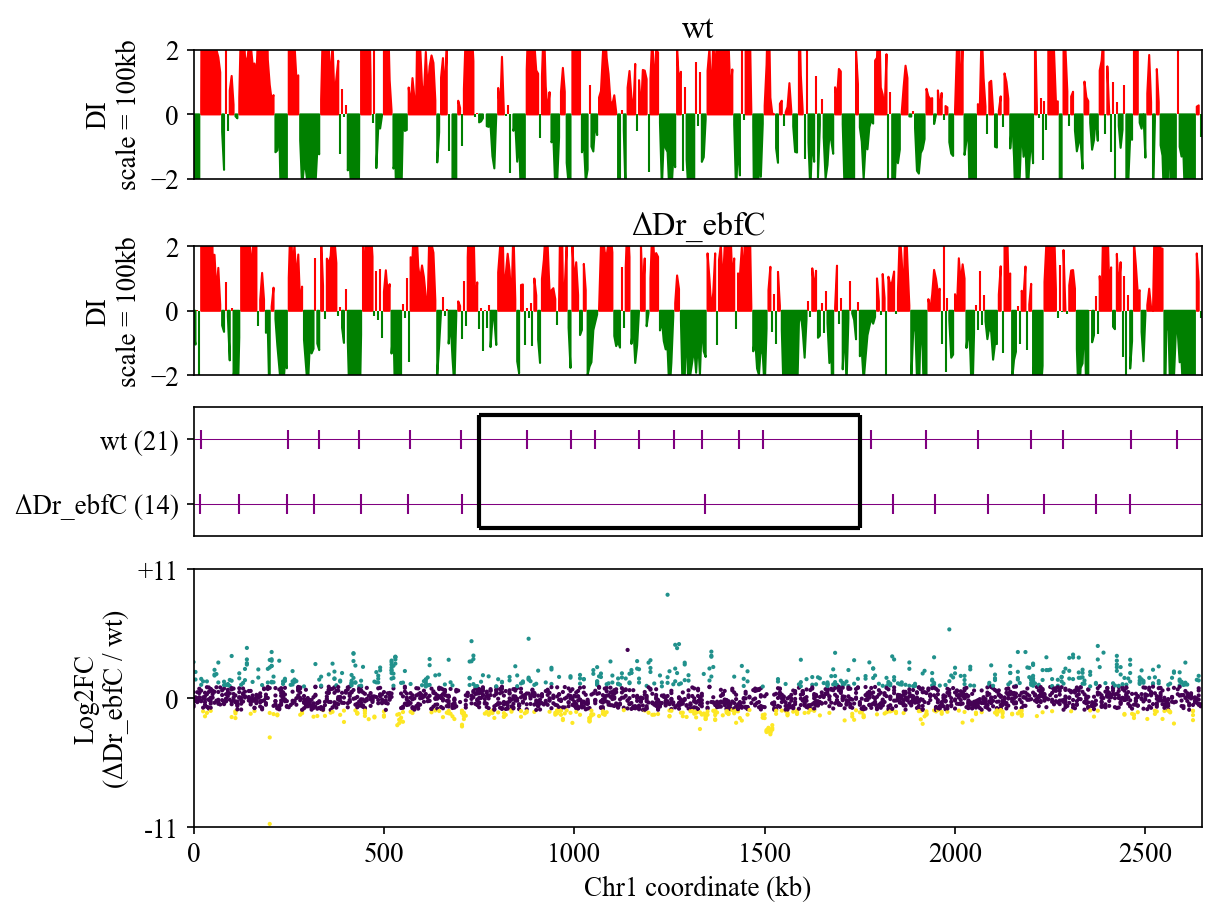

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=150, constrained_layout=True)
plt.rc('font',family='Times New Roman')
matplotlib.rcParams.update({'font.size': 13})

gs = gridspec.GridSpec(5, 1, figure=fig)
ax0 = plt.subplot(gs[0])
borders = list(range(len(wt_DI20_chr1)))
borders1 = np.array(wt_DI20_chr1[:,0])
ax0.set_xlim([0, 530])
ax0.set_ylim([-2, 2])
ax0.fill_between(borders, 0,borders1,borders1>=0, color='red')
ax0.fill_between(borders, 0,borders1,borders1<0, color='green')
ax0.set_ylabel("DI\nscale = 100kb")
ax0.set_title('wt')
ax0.xaxis.set_visible(False)

ax1 = plt.subplot(gs[1], sharex=ax0)
borders2 = np.array(ebfC_DI20_chr1[:,0])
ax1.set_ylim([-2, 2])
ax1.fill_between(borders, 0,borders2,borders2>=0, color='red')
ax1.fill_between(borders, 0,borders2,borders2<0, color='green')
ax1.set_ylabel("DI\nscale = 100kb")
ax1.set_title('ΔDr_ebfC')
ax1.xaxis.set_visible(False)

ax3 = plt.subplot(gs[2], sharex=ax0)
ax3.set_ylim([0, 0.8])
ax3.set_yticks([0.2,0.6])
ax3.set_yticklabels(['ΔDr_ebfC (14)', 'wt (21)'])
ax3.hlines([0.2, 0.6], 0, 530, color ="purple", lw=0.5)
for i in CID_Boundary1:
    ax3.vlines((i[0]+i[1])/2, 0.54, 0.66, colors='purple', lw=1)
for i in ebfC_CID_Boundary1:
    ax3.vlines((i[0]+i[1])/2, 0.14, 0.26, colors='purple', lw=1)
ax3.vlines(150, 0.05, 0.75, colors='black', lw=2)
ax3.vlines(350, 0.05, 0.75, colors='black', lw=2)
ax3.hlines(0.05, 150, 350, colors='black', lw=2)
ax3.hlines(0.75, 150, 350, colors='black', lw=2)
ax3.xaxis.set_visible(False)

ax4 = plt.subplot(gs[3:,:], sharex=ax0)
ax4.scatter("bin", "log2FoldChange",
                data = diff_data, s = 1, c = label)
ax4.set_ylim([-11, 11])
plt.yticks([-11,0,11], [-11,0,'+11'])
tick_locs = range(0,530,100)
tick_lbls = (np.array( range(0,530,100)) * 5 ).tolist()
plt.xticks(tick_locs, tick_lbls)
ax4.set_xlabel("Chr1 coordinate (kb)")
ax4.set_ylabel("Log2FC\n(ΔDr_ebfC / wt)")

plt.savefig("../pictures/ebfC_DEGs_distribution.jpg", bbox_inches='tight', dpi=300)